# Mode-Turbulence Coupling: Numerical Analysis
# M = 10^3, < Delta_tau > = 4pi, K = 4, eta M^2 = 0.04

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

# flattens nested arrays into one dimensional arrays
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

## Physical Parameters

In [2]:
# eta * Ma ^2 = 0.04
Ma = 0.04 ** (1/2)
K = 4
eta = 1

## Functions of Ma

In [3]:
meandeltaT = 4*np.pi

# variables for generating F2, H, and G1
stdF2 = eta * Ma**2
limitY2 = eta 

## Calculation parameters

In [4]:
L = 1
M = 10**3
M_short = 200
N = 1
m = 10**2

J = 300
dTau= 2 * np.pi / J

Tr = K * meandeltaT

Tmax = 2 * np.pi * M

## Initial Conditions

In [5]:
initial_AT = 0
initial_dAdT = 0

### Functions

In [6]:
def fundeltaT(n_bins, M, dTau):
    Tturb = [0]
    deltaT = []
    
    # generate a rayleigh distribution from which to pick values for deltaT from
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        # picks a random value from the rayleigh distribution
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        
        # rounds deltaTtemp up or down to be an interger multiple of dTau
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
            
        deltaT.append(deltaTtemp2[0])
        Tturb.append(deltaTtemp2 + Tturb[i])
        
    Tturb.pop(-1)
    Tturb.pop(-1)
    return deltaT, Tturb

### F_k Function

In [7]:
# generating F2, G1
def funF_k(std, limit, deltaT):
    F_k =[]
    y1 = 0
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
        
    return F_k

# generating F1
def fundHdt(std, limit, deltaT, Tturb):
    dHdt =[]
    time = []
    y1 = 0
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], int(deltaT[i] / dTau)):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                time.append(j + Tturb[i])
                # calculated the derivative of H = 16 * y1 * x**2 * (1 - x)**2
                dHdt.append(1 / deltaT[i] * 32 * y1 * x * (2 * x**2 - 3 * x + 1))
        
    return dHdt, time

def funAmp(F1, F2, G1, dTau, A, dAdt):
    # huen's method
    # u = dA/dt
    
    D = 0
    Amp = [A]
    t = 0.0
    amptime = [t]
    u = dAdt
    
    for i in range(0, int(len(F1)) -2):
        m1 = u
        k1 = -((D + F1[i]) * u ) - ( 1 + G1[i] ) * A + F2[i]
        m2 = u + dTau * k1
        A_2 = A + dTau * m1
        u_2 = m2
        k2 = -((D + F1[i + 1]) * u_2 ) - ( 1 + G1[i + 1] ) * A_2 + F2[i + 1]
        m2 = u + dTau * k2
        t = t + dTau
        A = A + (dTau / 2) * (m1 + m2)
        u = u + (dTau / 2) * (k1 + k2)
        Amp.append(A)
        amptime.append(t)

    Amp = Amp[:-1]
    amptime = amptime[:-1]
    
    return Amp, amptime

### Plotting Functions

In [8]:
def Funplots(t, g1, f1, f2):

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2081', **axis_font)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(40,10))
    plt.plot(t, g1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('G\u2081', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2082', **axis_font)
    plt.tight_layout()
    plt.show()
    
def FunplotAmp(amptime, Amp):
    plt.figure(figsize=(40,10))
    plt.plot(amptime, Amp, 'k')
    plt.title('Amplitude of the Mode', **title_font)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

In [9]:
# root mean square
def FunRMS(B):
    sqr = [a**2 for a in B]
    avg = sum(sqr)/len(sqr)
    return avg**(1/2)

## Plots

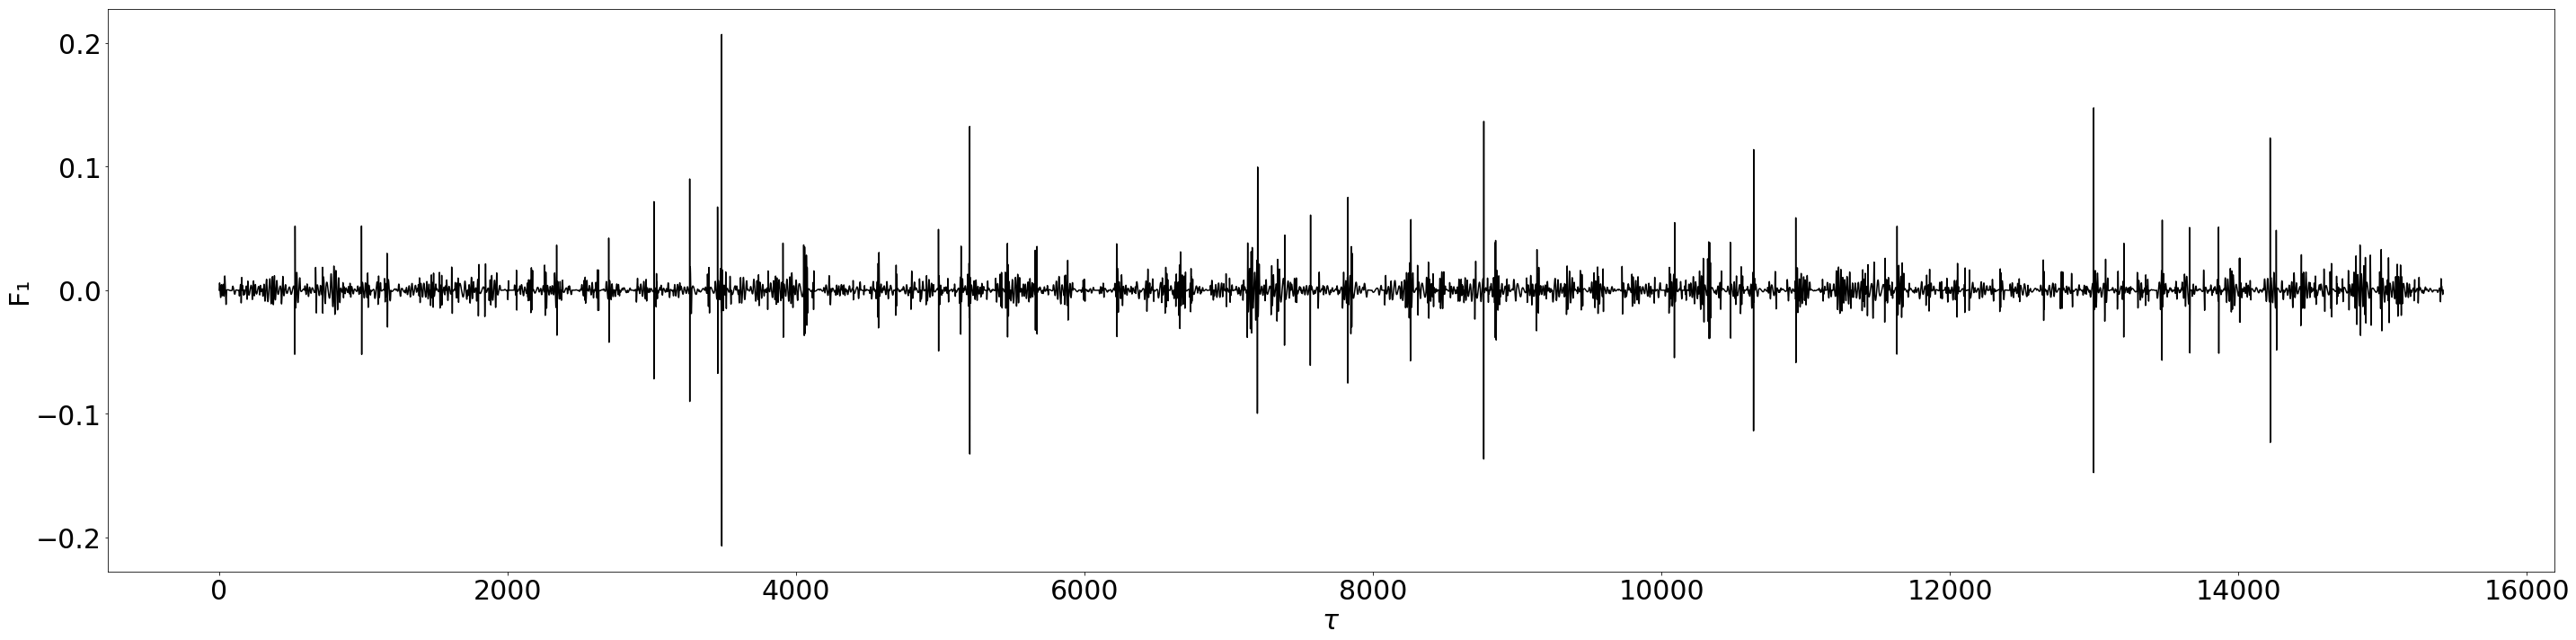

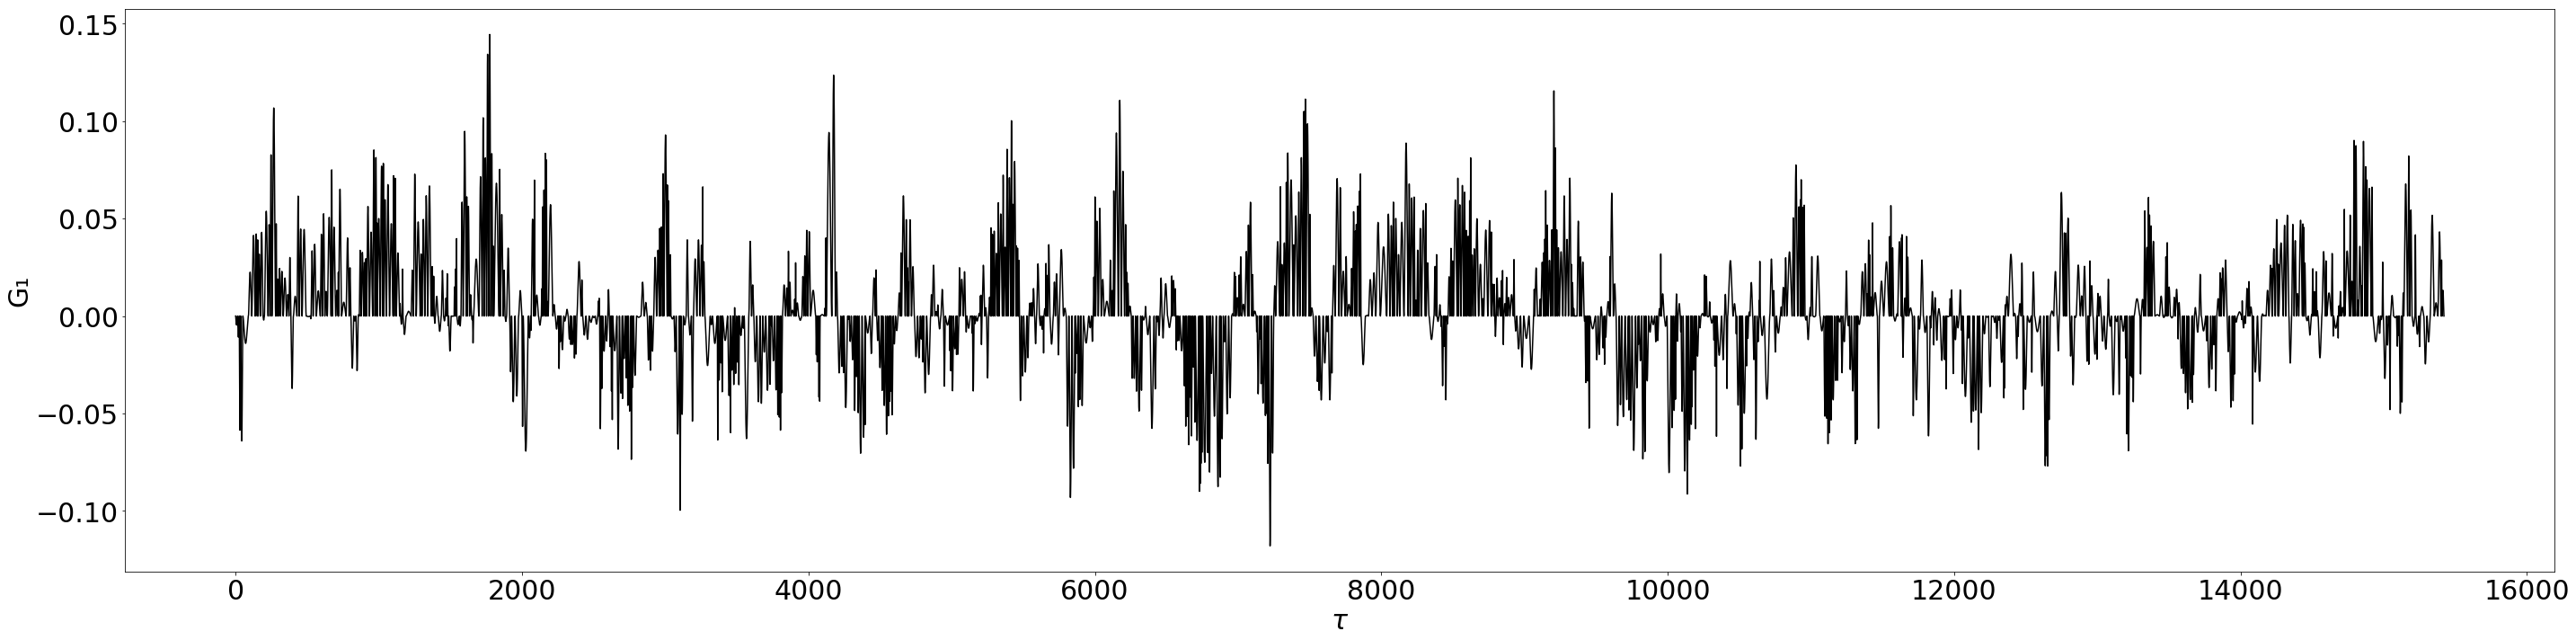

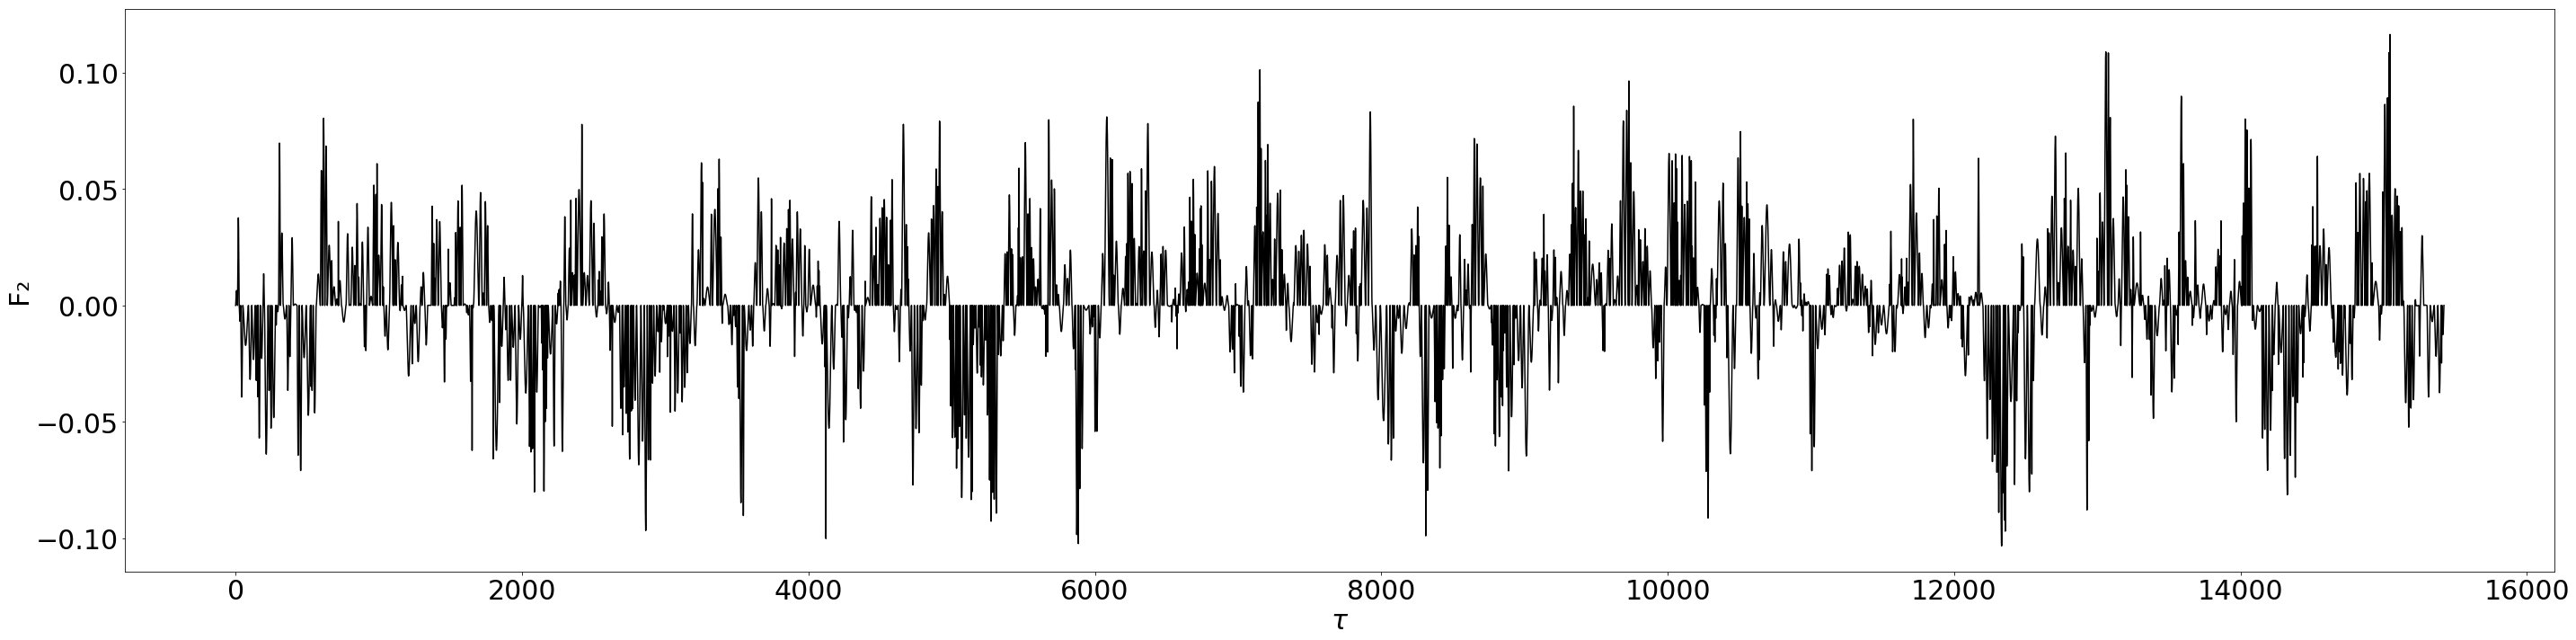

In [11]:
deltaT, Tturb = fundeltaT(n_bins, M, dTau)

# generate F1, F2, G1
F1, time = fundHdt(stdF2, limitY2, deltaT, Tturb)
F2 = funF_k(stdF2, limitY2, deltaT)
G1 = funF_k(stdF2, limitY2, deltaT)
    
Funplots(time, G1, F1, F2)

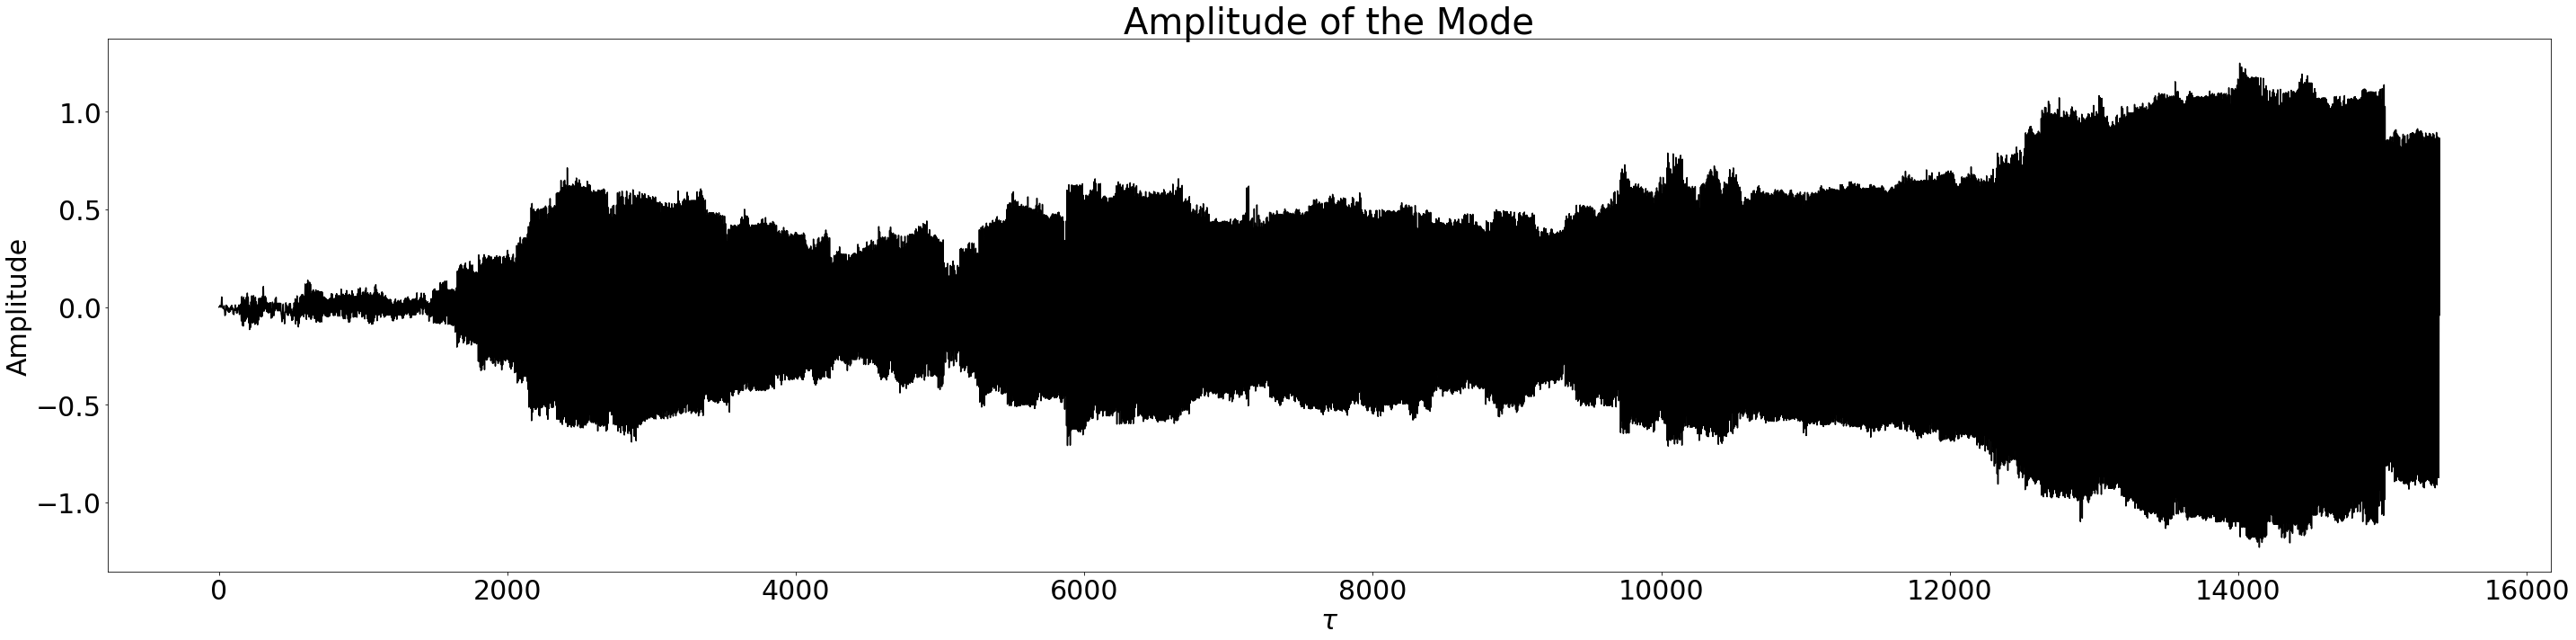

In [12]:
Amp, amptime = funAmp(F1, F2, G1, dTau, initial_AT, initial_dAdT)

FunplotAmp(amptime, Amp)

## Table 1 Values

In [13]:
F1rms = FunRMS(F1)
print("<F1^2>^(1/2) = ", F1rms)

G1rms = FunRMS(G1)
print("<G1^2>^(1/2) = ", G1rms)

F2rms = FunRMS(F2)
print("<F2^2>^(1/2) = ", F2rms)

Arms = FunRMS(Amp)
print("<A^2>^(1/2) =", Arms ** 2 )

<F1^2>^(1/2) =  0.006638105975457008
<G1^2>^(1/2) =  0.02567223107975487
<F2^2>^(1/2) =  0.02423847930251979
<A^2>^(1/2) = 0.19244580251173626
